In [145]:
import pandas as pd
import numpy as np
import re
import os
import sys
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
TOP_PATH = os.environ['PWD']

In [9]:
sys.path.append(TOP_PATH + '/config')
sys.path.append(TOP_PATH + '/src')

In [149]:
from trends import *
import etl
from regression import regression

In [11]:
test_date = '10-11-2018'
test_date_2 = '11-12-2018'

In [14]:
df_2017 = pd.read_csv(TOP_PATH + '/data/cleaned/2017_cleaned.csv')

In [16]:
df_2018_2019 = pd.read_csv(TOP_PATH + '/data/cleaned/2018-2019_cleaned.csv')

In [20]:
df_2014 = pd.read_csv(TOP_PATH + '/data/cleaned/2014_cleaned.csv')

In [21]:
df_2015 = pd.read_csv(TOP_PATH + '/data/cleaned/2015_cleaned.csv')

In [22]:
df_2016 = pd.read_csv(TOP_PATH + '/data/cleaned/2016_cleaned.csv')

In [156]:
df_2018_2019['subject_race'].unique()

array(['White', 'Hispanic/Latino/a', 'Black/African American',
       'Native American', 'Middle Eastern or South Asian', 'Asian',
       'Pacific Islander'], dtype=object)

In [52]:
#DACA example for regression
# [2017,7,5] to [2017,11,5]
start_date = pd.to_datetime('07-05-2017')
end_date = pd.to_datetime('11-05-2017')
event_date = pd.to_datetime('09-05-2017')
df_regr = df_2017.copy()
df_regr = df_regr[[start_date <= pd.to_datetime(x) and end_date >= pd.to_datetime(x) for x in df_regr['date_stop']]]

In [53]:
df_regr_hisp = df_regr.copy()

In [54]:
df_regr_hisp['Hispanic'] = [1 if x == 'Hispanic/Latino/a' else 0 for x in df_regr_hisp['subject_race']]

In [73]:
daca_df = pd.read_csv(TOP_PATH + '/data/raw/DACA.csv')

In [74]:
daca_df.drop('Unnamed: 0', inplace = True, axis = 1)

In [87]:
temp = df_regr_hisp[['date_stop', 'Hispanic']].groupby('date_stop').mean().reset_index()

In [88]:
temp

,date_stop,Hispanic
0,2017-07-05,0.308989
1,2017-07-06,0.342657
2,2017-07-07,0.287671
3,2017-07-08,0.295547
4,2017-07-09,0.370861
...,...,...
118,2017-10-31,0.261307
119,2017-11-01,0.234973
120,2017-11-02,0.191176
121,2017-11-03,0.277778


In [86]:
daca_df.reset_index()

,date,value
0,2017-07-05,<1
1,2017-07-06,1
2,2017-07-07,<1
3,2017-07-08,<1
4,2017-07-09,<1
...,...,...
119,2017-11-01,1
120,2017-11-02,2
121,2017-11-03,1
122,2017-11-04,1


In [103]:
daca_df['value'] = [int(x) if x.isnumeric() else 0 for x in daca_df['value']]

In [105]:
df = temp.merge(daca_df, left_on = 'date_stop', right_on = 'date')

In [117]:
df = df.sort_values('value').reset_index(drop = True)

In [140]:
reg = LinearRegression().fit(df['value'].values.reshape(-1,1), df['Hispanic'].values)

In [146]:
df

,date_stop,Hispanic,value
0,2017-07-05,0.308989,0
1,2017-08-05,0.275000,0
2,2017-08-06,0.246231,0
3,2017-07-30,0.251397,0
4,2017-08-21,0.421941,0
...,...,...,...
118,2017-09-01,0.353846,19
119,2017-09-07,0.321678,37
120,2017-09-04,0.330961,44
121,2017-09-06,0.302872,79


In [141]:
reg.coef_

array([0.00051768])

In [142]:
reg.intercept_

0.29590542642929457

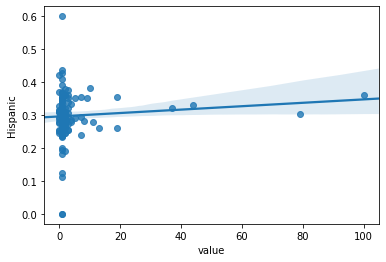

In [147]:
sns.regplot(df['value'], df['Hispanic'], scatter = True, fit_reg = True)

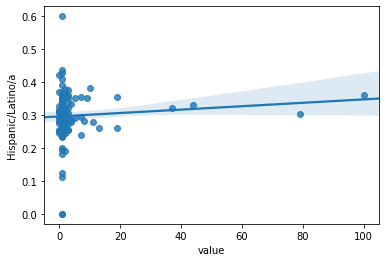

In [153]:
x = regression(('07-05-2017', '11-05-2017'), 'Hispanic/Latino/a', 'DACA')

In [160]:
x.coef_

array([0.00051768])

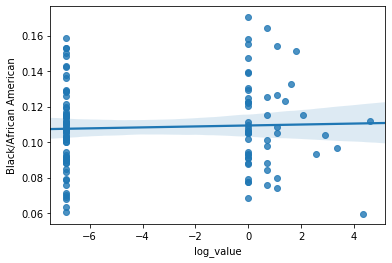

In [162]:
y = regression(('07-08-2014', '11-08-2014'), 'Black/African American', 'Ray Rice')

In [163]:
y.coef_

array([0.00026923])

In [164]:
df_2018_2019

,Unnamed: 0,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,0,2443,Reasonable Suspicion,120,White,Male,25,2018-07-01,00:01:37,Y,N,NaN,N,N
1,1,2444,Traffic Violation,120,White,Male,25,2018-07-01,00:03:34,N,N,NaN,N,N
2,2,2447,Reasonable Suspicion,820,Hispanic/Latino/a,Male,30,2018-07-01,00:05:43,N,N,NaN,N,N
3,3,2448,Traffic Violation,610,White,Male,23,2018-07-01,00:19:06,N,N,NaN,N,N
4,4,2449,Reasonable Suspicion,110,White,Male,25,2018-07-01,00:03:00,Y,Y,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235505,241285,255143,Traffic Violation,510,Hispanic/Latino/a,Male,19,2019-12-31,11:57:00,N,N,NaN,N,N
235506,241286,255256,Traffic Violation,520,Middle Eastern or South Asian,Male,58,2019-12-31,22:42:00,N,N,NaN,N,N
235507,241287,255267,Reasonable Suspicion,520,Asian,Male,35,2019-12-31,23:59:37,Y,N,NaN,N,N
235508,241288,255272,Reasonable Suspicion,520,Asian,Male,40,2019-12-31,22:20:32,Y,N,NaN,N,N


In [169]:
df_2018_2019 = pd.read_csv(TOP_PATH + '/data/raw/STOPS_2018-2019.csv')

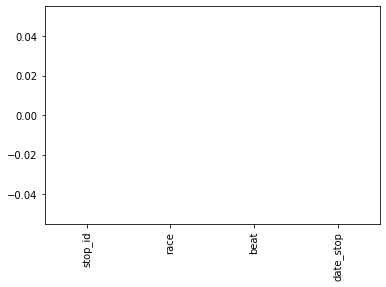

In [178]:
df_2018_2019[['stop_id', 'race', 'beat', 'date_stop']].isnull().mean().plot(kind = 'bar')

In [175]:
df_2014 = pd.read_csv(TOP_PATH + '/data/raw/STOPS_2014.csv')

In [180]:
df_2014[['stop_id', 'subject_race', 'service_area', 'date_stop']].isnull().mean()#.plot(kind = 'bar')

stop_id         0.00000
subject_race    0.00154
service_area    0.00000
date_stop       0.00000
dtype: float64

In [181]:
df_2015 = pd.read_csv(TOP_PATH + '/data/raw/STOPS_2015.csv')

In [182]:
df_2015[['stop_id', 'subject_race', 'service_area', 'date_stop']].isnull().mean()#.plot(kind = 'bar')

stop_id         0.000000
subject_race    0.002183
service_area    0.000000
date_stop       0.000000
dtype: float64

In [183]:
df_2016 = pd.read_csv(TOP_PATH + '/data/raw/STOPS_2016.csv')

In [184]:
df_2016[['stop_id', 'subject_race', 'service_area', 'date_stop']].isnull().mean()#.plot(kind = 'bar')

stop_id         0.000000
subject_race    0.001271
service_area    0.000000
date_stop       0.000000
dtype: float64

In [185]:
df_2017 = pd.read_csv(TOP_PATH + '/data/raw/STOPS_2017.csv')

In [186]:
df_2017[['stop_id', 'subject_race', 'service_area', 'date_stop']].isnull().mean()#.plot(kind = 'bar')

stop_id         0.000000
subject_race    0.001238
service_area    0.000000
date_stop       0.000000
dtype: float64

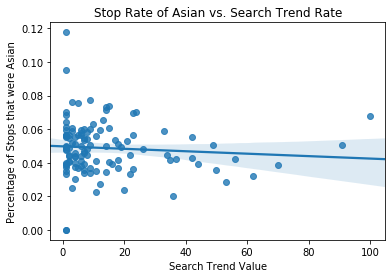

In [193]:
cra = regression(('06-15-2018', '10-15-2018'), 'Asian', 'Crazy Rich Asians')

In [194]:
cra.coef_

array([-7.28118375e-05])